# Tutorial 1: Poisson problem with Dirichlet conditions and code validation

This tutorial is forged from the [first and second Gridap tutorial](https://gridap.github.io/Tutorials/stable/).

In this tutorial, we will learn
- How to solve a Poisson problem with inhomogeneous Dirichlet boundary conditions using Gridap
- How to implement the method of manufactured solutions
- How to perform a convergence test
- How to define the discretization error
- How to integrate error norms
- How to generate Cartesian meshes in arbitrary dimensions

## Problem statement

In this tutorial, we show how to validate a code using the well known *method of manufactured solutions*. For the sake of simplicity, we consider the Poisson equation in the unit square $\Omega\doteq (0,1)^2$ as a model problem,


$$
\left\lbrace
\begin{aligned}
-\Delta u = f  \ \text{in} \ \Omega\\
u = g \ \text{on}\ \partial\Omega.\\
\end{aligned}
\right.
$$

We are going to consider two different manufactured solutions. On the one hand, we consider function $u(x)=x_1+x_2$, which can be exactly represented by the FE interpolation that we construct below.

**Question.** Can you prove this? 
*Hint* Remember Cea's lemma.




As a result, one expects that the obtained approximation error is near the machine precision. We are going to check that this is true in the code. On the other hand, we consider a function that cannot be captured exactly by the interpolation, namely $u(x)=x_1^3 + x_2^3$. Here, our goal is to confirm that the convergence order of the discretization error is the optimal one.


## Manufactured solution

We start by defining the manufactured solution $u(x) = x_1+x_2$ and the source term $f$ associated with it, namely $f\doteq-\Delta(x_1+x_2)=0$.

In [1]:
using Gridap

u(x) = x[1] + x[2]
f(x) = 0

f (generic function with 1 method)

We also need to define the gradient of $u$ since we will compute the $H^1$ error norm later. In that case, the gradient is simply defined as

In [2]:
∇u(x) = VectorValue(1,1)

∇u (generic function with 1 method)

Note that we have used the constructor `VectorValue` to build the vector that represents the gradient. However, we still need a final trick. We need to tell the Gridap library that the gradient of the function `u` is available in the function `∇u` (at this moment `u` and `∇u` are two standard Julia functions without any connection between them). This is done by adding an extra method to the function `gradient` (aka `∇`) defined in Gridap:

In [3]:
import Gridap: ∇
∇(::typeof(u)) = ∇u

gradient (generic function with 29 methods)

Now, it is possible to recover function `∇u` from function `u` as `∇(u)`. You can check that the following expression evaluates to `true`.

In [4]:
∇(u) === ∇u

true

Note: the definition of the gradient is optional. If not provided, the gradient will be computed with automatic differentiation.

## Mesh generation

In order to discretize the geometry of the unit square, we use the Cartesian mesh generator available in Gridap.
This will generate a structured mesh consisting of quadrilaterals and we turn this mesh into a triangulated mesh
consisting of triangles by sending the quadrilateral mesh to the `simplexify` function via Julia's pipe/chain operator `|>`.


In [5]:
domain = (0,1,0,1)
nx, ny = 4, 4
partition = (nx,ny)
model = CartesianDiscreteModel(domain,partition) |> simplexify

UnstructuredDiscreteModel()

The type `CartesianDiscreteModel` is a concrete type that inherits from `DiscreteModel`, which is specifically designed for building Cartesian meshes. The `CartesianDiscreteModel` constructor takes a tuple containing limits of the box we want to discretize  plus a tuple with the number of cells to be generated in each direction (here 4 by 4 cells). Note that the `CaresianDiscreteModel` is implemented for arbitrary dimensions. For instance, the following lines build a `CartesianDiscreteModel`  for the unit cube $(0,1)^3$ with 4 cells per direction

In [6]:
domain3d = (0,1,0,1,0,1)
partition3d = (4,4,4)
model3d = CartesianDiscreteModel(domain3d,partition3d)

CartesianDiscreteModel()

You could also generate a mesh for the unit tesseract $(0,1)^4$ (i.e., the unit cube in 4D). Look how the 2D and 3D models are built and just follow the sequence.

Let us return to the 2D `CartesianDiscreteModel` that we have already constructed. You can inspect it by writing it into vtk format
and opening it with a suitable visualization tool, e.g. [Paraview](https://www.paraview.org/).
To inspect the file using Paraview, you need to install Paraview locally on your computer and download the vtk file.
Later in this tutorial we will see, how to visualize meshes, discrete solutions etc. directly in our Jupyterhub. 

In [8]:
writevtk(model,"model")

3-element Vector{Vector{String}}:
 ["model_0.vtu"]
 ["model_1.vtu"]
 ["model_2.vtu"]

If you open the generated files, you will see that the boundary
vertices and facets are identified with the name "boundary".  This is
just what we need to impose the Dirichlet boundary conditions in this
example. The objects on the boundary are correctly tagged with the
name "boundary".

## FE spaces approximation

 Once we have a discretization of the computational domain, the next
 step is to generate a discrete approximation of the finite element
 spaces $V_0$ and $V_g$ (i.e. the test and trial FE spaces) of the
 problem. To do so, first, we are going to build a discretization of
 $V_0$ as the standard Conforming Lagrangian FE space (with zero
 boundary conditions) associated with the discretization of the
 computational domain. The approximation of the FE space $V_0$ is
 built as follows:

In [9]:
order = 1
reffe = ReferenceFE(lagrangian,Float64,order)
V0 = TestFESpace(model,reffe,conformity=:H1,dirichlet_tags="boundary")


UnconstrainedFESpace()

Here, we have used the `TestFESpace` constructor, which constructs a particular FE space (to be used as a test space) from a set of options described as positional and key-word arguments. The first positional argument is the model on top of which we want to build the space. The second positional argument contains information about the type of FE interpolation (the reference FE in this case). With `ReferenceFE(lagrangian,Float64,order)` We select a scalar-valued Lagrangian reference FE of order 1, where the value of the shape functions will be represented with  64-bit floating point numbers. With the key-word argument `conformity` we define the regularity of the interpolation at the boundaries of the cells in the mesh. Here, we use `conformity=:H1`, which means that the resulting interpolation space is a subset of $H^1(\Omega)$ (i.e., continuous shape functions). On the other hand, we pass the identifiers of the Dirichlet boundary via the `dirichlet_tags` argument. In this case, we mark as Dirichlet all objects of the discrete model identified with the `"boundary"` tag. Since this is a test space, the corresponding shape functions vanishes at the Dirichlet boundary.

Once the space $V_0$ is discretized in the code, we proceed with the approximation of the trial space $V_g$.

In [10]:
Vg = TrialFESpace(V0,u)

TrialFESpace()

To this end, we have used the `TrialFESpace` constructors. Note that we have passed a function representing the value of the Dirichlet boundary condition, when building the trial space.


## Numerical integration

Once we have built the interpolation spaces, the next step is to set up the machinery to perform the integrals in the weak form numerically. Here, we only need to compute integrals on the interior of the domain $\Omega$.
To do so, we need two main ingredients:
1. We need to define an integration mesh (i.e. a triangulation of the integration domain)
2. A Gauss-like quadrature in each of the cells in the triangulation. 

In Gridap, integration meshes are represented by types inheriting from the abstract type `Triangulation`. For integrating on the domain $\Omega$, we build the following triangulation and the corresponding Lebesgue measure, which will allow to write down integrals in a syntax similar to the usual mathematical notation.

In [11]:
degree = 2
Ω = Triangulation(model)
dΩ = Measure(Ω,degree)

Measure()


Here, we build a triangulation from the cells of the model and build (an approximation of) the Lebesgue measure using a quadrature rule of degree 2 in the cells of this triangulation. This is enough for integrating the corresponding terms of the weak form exactly for an interpolation of order 1.

## Weak form

With all the ingredients presented so far, we are ready to define the weak form. This is done by defining to functions representing the bi-linear and linear forms:

In [12]:
a(u,v) = ∫( ∇(v)⊙∇(u) )*dΩ
b(v) = ∫( v*f )*dΩ

b (generic function with 1 method)

Note that by using the integral function `∫`, the Lebesgue measure `dΩ`, and the gradient function `∇`, the weak form is written with an obvious relation with the corresponding mathematical notation.

## FE Problem

 At this point, we can build the FE problem that, once solved, will provide the numerical solution we are looking for. A FE problem is represented in Gridap by types inheriting from the abstract type `FEOperator` (both for linear and nonlinear cases). Since we want to solve a linear problem, we use the concrete type `AffineFEOperator`, i.e., a problem represented by a matrix and a right hand side vector.
 Here, we don

In [13]:
op = AffineFEOperator(a,b,Vg,V0)

uh = solve(op)

SingleFieldFEFunction():
 num_cells: 32
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 4698034869255265672

Note that we are imposing Dirichlet boundary conditions on the objects tagged as "boundary" and that we are using the manufactured solution `u` to construct the trial FE space. Not also that we are not explicitly constructing an `Assembler` object nor a `FESolver`. We are relying on default values.

The `solve` function returns the computed numerical solution `uh`. This object is an instance of `FEFunction`, the type used to represent a function in a FE space. 

## Visualization

Similar to what we did to inspect the Cartesion Grid Model, we can also inspect the result `uh` by writing it into a `vtk` file and using Paraview:

In [14]:
writevtk(Ω, "results", cellfields=["uh"=>uh])

(["results.vtu"],)

Direct visualization using our Jupyterhub poses some extra challenges, since we run our notebooks on a headless server with does not
provides a display server or access to OpenGL functionality to draw scenes.
Instead, we can the `GridapMakie` package together with the `CairoMakie` to plot non-interactive 2D/3D vector graphics.

First make sure that you have install the `GridapMakie`, `CairoMakie`, and the `FileIO` packages.
You can do that in a separate Julia REPL you open via a Terminal launched from the JupyterHub launcher page,
or you can do it directly from within the notebook:

In [15]:
import Pkg
Pkg.add(["GridapMakie", "CairoMakie", "FileIO"])

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Documents/repositories/courses/ntnu/tma4183-optimization-II/Project.toml`
  No Changes to `~/Documents/repositories/courses/ntnu/tma4183-optimization-II/Manifest.toml`


Now let's use it. First, we draw the (triangulation) mesh and its corresonding nodes.

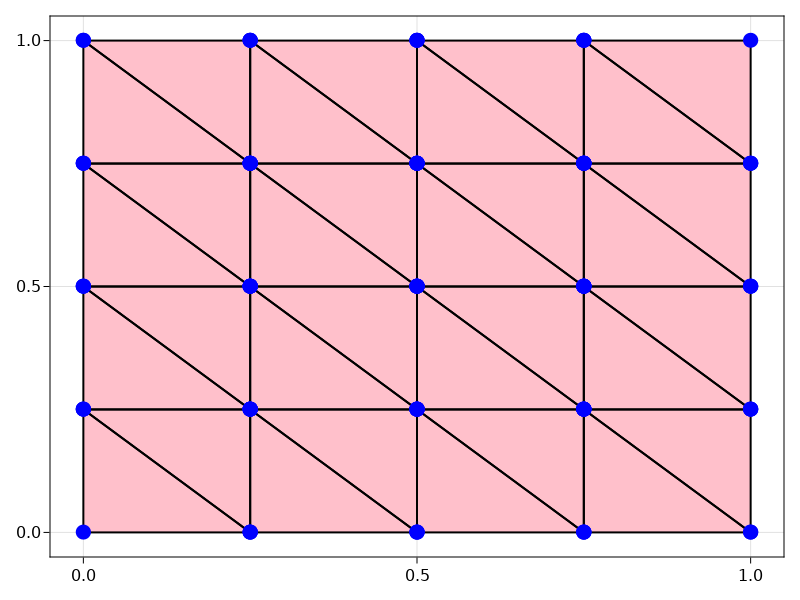

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x000000001004c3c0, 600.0, 450.0, IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1))


In [16]:
# make a triangulation
using GridapMakie, CairoMakie, FileIO
fig = plot(Ω)
# Plot edges of each element
wireframe!(Ω, color=:black, linewidth=2)
# Plot mesh nodes
scatter!(Ω, marker=:circle, markersize=20, color=:blue)
# Don't forget to display the figue
display(fig)
# And finally save it.
save("mesh_nx_$(nx)_ny_$(ny).svg", fig)

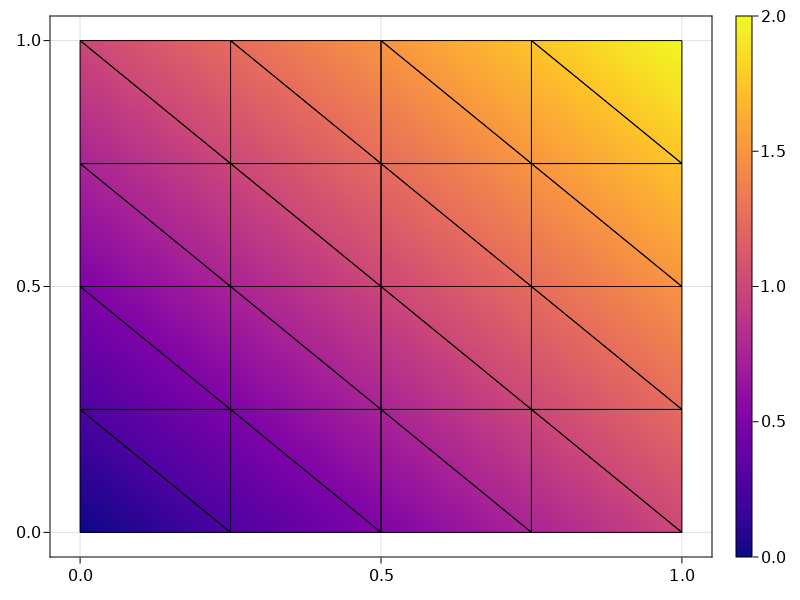

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x000000001106d9a0, 600.0, 450.0, IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1))


In [17]:
fig, _ , plt = plot(Ω, uh, colormap=:plasma)
wireframe!(Ω, color=:black, linewidth=1)
Colorbar(fig[1,2], plt)
display(fig)
save("uh_nx_$(nx)_ny_$(ny).svg", fig)

## Measuring the discretization error

Our goal is to check that the discratization error associated with the computed approximation `uh` is close to machine precision. To this end, the first step is to compute the discretization error, which is done as you would expect:

In [18]:
e= u - uh 

OperationCellField():
 num_cells: 32
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 4698034869255265672

Once the error is defined, you can, e.g., visualize it.

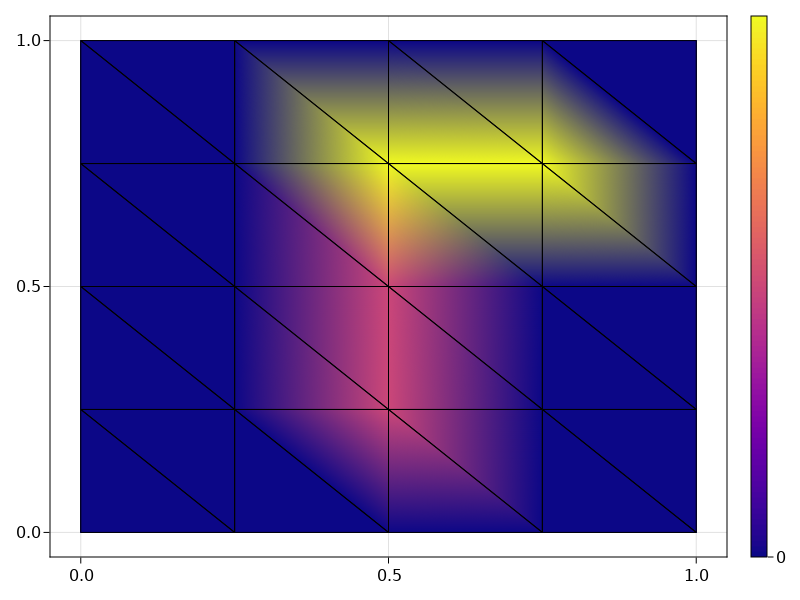

┌ Warning: No strict ticks found
└ @ PlotUtils /home/andre/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /home/andre/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /home/andre/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /home/andre/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /home/andre/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /home/andre/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /home/andre/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /home/andre/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /home/andre/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333


CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x0000000010d19520, 600.0, 450.0, IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1))


In [19]:
# For Paraview
writevtk(Ω,"error",cellfields=["e" => e])

# In place visualization
fig, _ , plt = plot(Ω, e, colormap=:plasma)
wireframe!(Ω, color=:black, linewidth=1)
Colorbar(fig[1,2], plt)
display(fig)
save("eh_nx_$(nx)_ny_$(ny).svg", fig)


This generates a file called `error.vtu`. Open it with Paraview to check that the error is of the order of the machine precision.

![](../assets/validation/error.png)

A more rigorous way of quantifying the error is to measure it with a norm. Here, we use the $L^2$ and $H^1$ norms, which are defined as

$$
\| w \|_{L^2}^2 \doteq \int_{\Omega} w^2 \ \text{d}\Omega, \quad
\| w \|_{H^1}^2 \doteq \int_{\Omega} w^2 + \nabla w \cdot \nabla w \ \text{d}\Omega.
$$

In order to compute these norms, we use again the `∫` function and the integration measure `dΩ`, namely

In [20]:
el2 = sqrt(sum( ∫( e*e )*dΩ ))
eh1 = sqrt(sum( ∫( e*e + ∇(e)⋅∇(e) )*dΩ ))

5.795279984765681e-16

#### Exercise

The expression `∫( fun )*dΩ` returns an object storing the cell contributions of the integral of the given function `fun`.
 To end up with the desired error norms, one has to sum these contributions and take the square root. You can check that the computed error norms are close to machine precision (as one would expect).

In [21]:
tol = 1.e-10
@assert el2 < tol
@assert eh1 < tol

## Convergence test

We end up this tutorial by performing a convergence test, where we are going to use all the new concepts we have learned.  We will consider a manufactured solution that does not belong to the FE interpolation space. In this test, we expect to see the optimal convergence order of the FE discretization.

Here, we define the manufactured functions

In [22]:
p = 3
u(x) = x[1]^p+x[2]^p
∇u(x) = VectorValue(p*x[1]^(p-1),p*x[2]^(p-1))
f(x) = -p*(p-1)*(x[1]^(p-2)+x[2]^(p-2))

f (generic function with 1 method)

Since we have redefined the valiables `u`, `∇u`, and `f`, we need to execute these lines again

In [23]:
∇(::typeof(u)) = ∇u
b(v) = ∫( v*f )*dΩ

b (generic function with 1 method)

In order to perform the convergence test, we write in a function all the code needed to perform a single computation and measure its error. The input of this function is the number of cells in each direction and the interpolation order. The output is the computed $L^2$ and $H^1$ error norms.

In [24]:
function run(n,k)

  domain = (0,1,0,1)
  partition = (n,n)
  model = CartesianDiscreteModel(domain,partition)

  reffe = ReferenceFE(lagrangian,Float64,k)
  V0 = TestFESpace(model,reffe,conformity=:H1,dirichlet_tags="boundary")
  U = TrialFESpace(V0,u)

  degree = 2*k
  Ω = Triangulation(model)
  dΩ = Measure(Ω,degree)

  a(u,v) = ∫( ∇(v)⊙∇(u) )*dΩ
  b(v) = ∫( v*f )*dΩ

  op = AffineFEOperator(a,b,U,V0)

  uh = solve(op)

  e = u - uh

  el2 = sqrt(sum( ∫( e*e )*dΩ ))
  eh1 = sqrt(sum( ∫( e*e + ∇(e)⋅∇(e) )*dΩ ))

  (el2, eh1)

end

run (generic function with 1 method)

The following function does the convergence test. It takes a vector of integers (representing the number of cells per direction in each computation) plus the interpolation order. It returns the $L^2$ and $H^1$ error norms for each computation as well as the corresponding cell size.

In [25]:
function conv_test(ns,k)

  el2s = Float64[]
  eh1s = Float64[]
  hs = Float64[]

  for n in ns

    el2, eh1 = run(n,k)
    h = 1.0/n

    push!(el2s,el2)
    push!(eh1s,eh1)
    push!(hs,h)

  end

  (el2s, eh1s, hs)

end

conv_test (generic function with 1 method)

We are ready to perform the test! We consider several mesh sizes and interpolation order $k=1$ and $k=2$ (for $k=3$ the error will be close to machine precision, as before, except if you change the value of $p$ above).

In [26]:
el2s1, eh1s1, hs = conv_test([8,16,32,64,128],1);
el2s2, eh1s2, hs = conv_test([8,16,32,64,128],2);

With the generated data, we do the classical convergence plot.

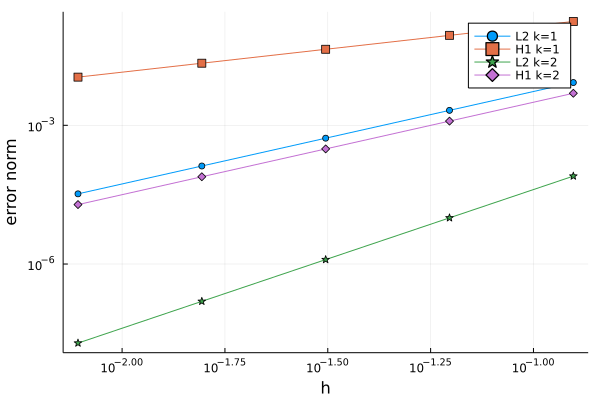

In [27]:
import Plots

Plots.plot(hs,[el2s1 eh1s1 el2s2 eh1s2],
    xaxis=:log, yaxis=:log,
    label=["L2 k=1" "H1 k=1" "L2 k=2" "H1 k=2"],
    shape=:auto,
    xlabel="h",ylabel="error norm")

The generated curves make sense. For a given interpolation order it is observed that the convergence of the $H^1$ error is slower that $L^2$ one whereas increasing the order makes convergence faster both in $L^2$ and in $H^1$. However, in order to be more conclusive, we need to compute the slope of these lines. It can be done with this little function that internally uses a linear regression.

In [28]:
function slope(hs,errors)
  x = log10.(hs)
  y = log10.(errors)
  linreg = hcat(fill!(similar(x), 1), x) \ y
  linreg[2]
end

slope (generic function with 1 method)

The slopes for the $L^2$ error norm is computed as

In [29]:
slope(hs,el2s1)
slope(hs,el2s2)

3.0000000018364967

and for the $H^1$ error norm as

In [30]:
slope(hs,eh1s1)
slope(hs,eh1s2)

2.000041821183346

As you can see,
the slopes for the $L^2$ and $H^1$ error norms are 2 and 1 for $k=1$ and 3 and 2 for $k=2$ respectively.